In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import os, re
import glob
import time

import sklearn
import statsmodels
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
import cv2 
import dlib
import urllib
import PIL
import imageio

# from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

# 1. Project_CIFAR-10 이미지 생성하기

### 1) 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
print("max pixel:", x_train.max())
print("min pixel:", x_train.min())

max pixel: 255
min pixel: 0


### 2) 데이터 전처리

In [4]:
x_train = x_train.astype('float32')
x_train = (x_train - 127.5) / 127.5

print("max pixel:", x_train.max())
print("min pixel:", x_train.min())

max pixel: 1.0
min pixel: -1.0


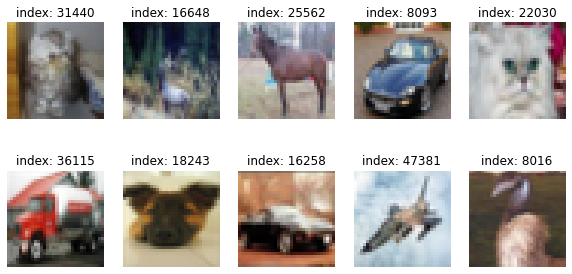

In [5]:
plt.figure(figsize=(10, 5))

for i in range(10):
    rd = np.random.randint(x_train.shape[0])
    plt.subplot(2, 5, i+1)
    Image = np.clip(x_train[rd], 0, 1)
    plt.imshow((x_train[rd] + 1)/2.0)
    plt.title(f'index: {rd}')
    plt.axis('off')
    
plt.show()

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 3) 생성자 모델 구현하기

In [7]:
def make_generator_model(momentum=0.9, alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    
    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))
    model.add(layers.Dropout(0.4))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.output_shape == (None, 32, 32, 3)
    
    return model

In [8]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1

In [9]:
noise = tf.random.normal([1, 100])

In [10]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

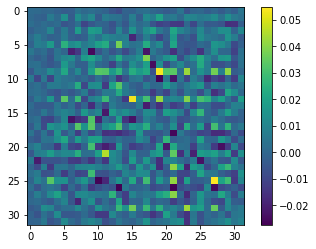

In [11]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

### 4) 판별자 모델 구현하기

In [12]:
def make_discriminator_model(alpha=0.2):

    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.4))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.4))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [14]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00277794]], dtype=float32)>

### 5) 손실함수와 최적화 함수 구현하기

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### 6) 훈련과정 상세 기능 구현하기

In [17]:
@tf.function
def train_step(images): 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [18]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1)/2.0)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [19]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [20]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 7) 학습 과정 진행하기

In [21]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [22]:
save_every = 5
EPOCHS = 50

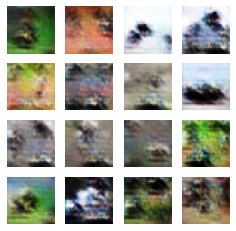

Time for training : 4113 sec


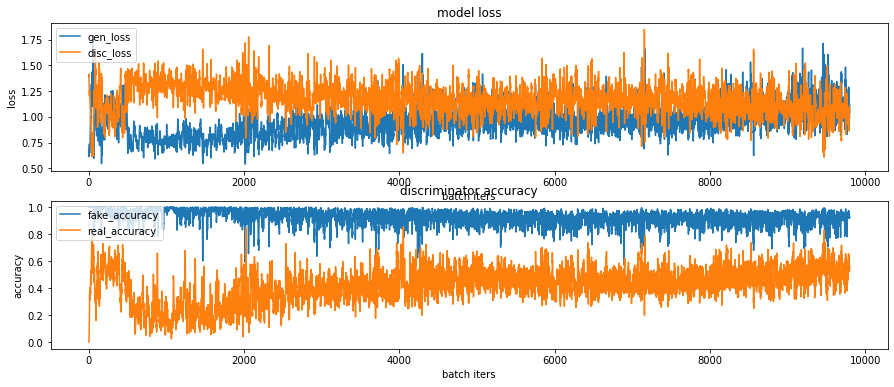

CPU times: user 1h 13min 48s, sys: 3min 14s, total: 1h 17min 2s
Wall time: 1h 8min 34s


In [23]:
%%time
train(train_dataset, EPOCHS, save_every)

In [24]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 3860145 Jan 23 13:36 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


# 2. GAN 훈련 과정 개선하기
generator_model_2 / EPOCHS = 300

In [25]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [26]:
def make_generator_model_2():
    
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8*8*128, activation='relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Reshape((8, 8, 128)))
    
    model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding='same', activation='tanh'))
    
    return model

In [27]:
generator2 = make_generator_model_2()
generator2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [28]:
noise = tf.random.normal([1, 100])
generated_image = generator2(noise, training=False)

In [ ]:
save_every = 5
EPOCHS = 200

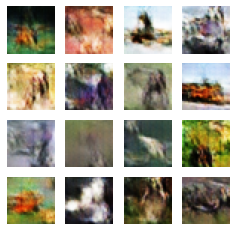

Epoch 76 | iter 51
Time for epoch 76 : 11 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

# 3. References

[1] https://lms.aiffel.io/course/382/node/508